In [1]:
import bagpy
from tqdm import tqdm
from typing import *
from shapely.geometry import *
from os.path import join, exists
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import geopandas as gpd

In [2]:
worlds_df = pd.read_pickle("/home/agusmazzeo/Documents/UTN/Proyecto/worlds_df.pkl")

In [3]:
worlds_df

,world,world_dir,starting_point,free_area,finished_false,finished_true
evaluation_7,<FrontierExploration.preprocessing.layout.synt...,/home/ramiro/.gazeboworlds/evaluation_7.world,"(44.3730343170481, 45.43376604621937)",1586.841949,True,True
evaluation_1,<FrontierExploration.preprocessing.layout.synt...,/home/ramiro/.gazeboworlds/evaluation_1.world,"(38.13039752687315, 44.08558532764939)",1207.029552,True,True
evaluation_5,<FrontierExploration.preprocessing.layout.synt...,/home/ramiro/.gazeboworlds/evaluation_5.world,"(30.162369766644044, 17.229534857934745)",1470.062424,True,True
evaluation_0,<FrontierExploration.preprocessing.layout.synt...,/home/ramiro/.gazeboworlds/evaluation_0.world,"(47.59203620653866, 21.969882899768308)",1093.128472,True,True
evaluation_9,<FrontierExploration.preprocessing.layout.synt...,/home/ramiro/.gazeboworlds/evaluation_9.world,"(27.146833573506807, 26.35109100999387)",1227.752651,True,True
...,...,...,...,...,...,...
evaluation_194,<FrontierExploration.preprocessing.layout.synt...,/home/ramiro/.gazeboworlds/evaluation_194.world,"(22.244891259682838, 5.356341056526373)",891.868292,False,False
evaluation_195,<FrontierExploration.preprocessing.layout.synt...,/home/ramiro/.gazeboworlds/evaluation_195.world,"(41.545717721344076, 10.354559752761045)",712.452498,False,False
evaluation_196,<FrontierExploration.preprocessing.layout.synt...,/home/ramiro/.gazeboworlds/evaluation_196.world,"(11.235190104396708, 7.134928722218135)",1313.795085,False,False
evaluation_197,<FrontierExploration.preprocessing.layout.synt...,/home/ramiro/.gazeboworlds/evaluation_197.world,"(49.83808475194827, 15.364919697504677)",1454.669774,False,False


In [4]:
worlds_df.index

Index(['evaluation_7', 'evaluation_1', 'evaluation_5', 'evaluation_0',
       'evaluation_9', 'evaluation_6', 'evaluation_3', 'evaluation_2',
       'evaluation_8', 'evaluation_10',
       ...
       'evaluation_186', 'evaluation_190', 'evaluation_191', 'evaluation_192',
       'evaluation_193', 'evaluation_194', 'evaluation_195', 'evaluation_196',
       'evaluation_197', 'evaluation_198'],
      dtype='object', length=163)

In [5]:
class BagpyDataHandler:
    
    def __init__(self, worlds_df: pd.DataFrame, outputs_dir: str):
        self.res_values = {}
        self.report = {}
        self.worlds = {}
        cont = 0
        for index in tqdm(worlds_df[worlds_df["finished_true"]].index):
            try:
                cont+=1
                # if cont == 10:
                #     break
                result = self.get_results_from_folder(join(outputs_dir, index))
                if result is not None:
                    self.res_values[index] = result
                    self.worlds[index] = worlds_df.loc[index]
                    self.report[index] = self.get_report_data(index, result)
            except Exception:
                continue
        reform = {(outerKey, innerKey): values for outerKey, innerDict in self.report.items() for innerKey, values in innerDict.items()}
        self.report_df = pd.DataFrame(reform)
                
    def get_report_data(self, index: str, result: Dict[str, Any]):
        report = {}
        world_polygon = self.worlds[index].world.free_space_polygon
        if isinstance(world_polygon, MultiPolygon):
            world_polygon = world_polygon.convex_hull
        for key in result.keys():
            if key not in report.keys():
                report[key] = {}
            poly = gpd.GeoDataFrame(geometry=[world_polygon.exterior])
            report[key] = {"trajectory": poly.append(result[key]["trajectory_df"]), **self.get_exploration_data(key, index, result)}
        return report
    
    def get_exploration_data(self, key: str, index: str, result: Dict[str, Any]):
        free_area = self.worlds[index]["free_area"]
        explored_per_distance = pd.merge_asof(result[key]["explored_df"], result[key]["travelled_distance_df"], on="timestamp")
        explored_area = explored_per_distance["m_2_explored"].iloc[-1]
        exploration = {
            "explored_percentage": 100*explored_area/free_area,
            "total_time_sec": explored_per_distance.index[-1],
            "dist_explored_20%": explored_per_distance.loc[explored_per_distance["m_2_explored"]<(20*free_area/100)].iloc[-1]["cum_distance"],
            "dist_explored_50%": explored_per_distance.loc[explored_per_distance["m_2_explored"]<(50*free_area/100)].iloc[-1]["cum_distance"],
            "dist_explored_80%": explored_per_distance.loc[explored_per_distance["m_2_explored"]<(80*free_area/100)].iloc[-1]["cum_distance"],
            "dist_explored_85%": explored_per_distance.loc[explored_per_distance["m_2_explored"]<(85*free_area/100)].iloc[-1]["cum_distance"],
            "dist_explored_90%": explored_per_distance.loc[explored_per_distance["m_2_explored"]<(90*free_area/100)].iloc[-1]["cum_distance"],
            "dist_explored_95%": explored_per_distance.loc[explored_per_distance["m_2_explored"]<(95*free_area/100)].iloc[-1]["cum_distance"],
            "dist_total": explored_per_distance.iloc[-1]["cum_distance"],
        }
        return exploration
            
    def get_results_from_folder(self, folder: str) -> Dict[str, Tuple[List[float], List[float]]]:
        try:
            utn_path = join(folder, "UTN")
            utn_dist_path = join(folder, "UTN_CON_DISTANCIA")
            maryland_path = join(folder, "MARYLAND")
            if not exists(utn_path) or not exists(maryland_path) or not exists(utn_dist_path):
                # print(f"Skipping {folder} because of not having both maryland and UTN")
                return None
            utn_bag_file = glob(join(utn_path, "*.bag"))[0]
            utn_dist_bag_file = glob(join(utn_dist_path, "*.bag"))[0]
            maryland_bag_file = glob(join(maryland_path, "*.bag"))[0]
            reader_utn = bagpy.bagreader(utn_bag_file)
            reader_utn_dist = bagpy.bagreader(utn_dist_bag_file)
            reader_maryland = bagpy.bagreader(maryland_bag_file)
            res = {
                "UTN": self.get_times_and_explores(reader_utn),
                "UTN_DIST": self.get_times_and_explores(reader_utn_dist),
                "MARYLAND": self.get_times_and_explores(reader_maryland)}
            return res
        except Exception as ex:
            print(f"An error ocurred on {folder}: {ex}")
            return None
    
    @staticmethod
    def get_explored_df(reader: bagpy.bagreader) -> pd.DataFrame:
        explored_data =  reader.reader.read_messages("/create1/explored")
        amt_of_non_unknown = []
        timestamps = []
        for d in explored_data:
            amt_of_non_unknown.append(d.message.data)
            timestamps.append(d.timestamp.to_sec())
        amt_of_non_unknown = [0.0025 * item for item in amt_of_non_unknown]
        dic = {"timestamp": timestamps, "m_2_explored": amt_of_non_unknown}
        df = pd.DataFrame(dic)
        df["timestamp"] -= dic["timestamp"][0]
        df = df.set_index("timestamp")
        return df

    @staticmethod
    def get_travelled_distance_df(reader: bagpy.bagreader) -> pd.DataFrame:
        travelled_data =  reader.reader.read_messages("/create1/travelled_distance")
        cum_distance = []
        timestamps = []
        for d in travelled_data:
            cum_distance.append(d.message.data)
            timestamps.append(d.timestamp.to_sec())
        dic = {"timestamp": timestamps, "cum_distance": cum_distance}
        df = pd.DataFrame(dic)
        df["timestamp"] -= dic["timestamp"][0]
        df = df.set_index("timestamp")
        return df

    @staticmethod
    def get_trajectory_df(reader: bagpy.bagreader) -> gpd.GeoDataFrame:
        gts =  reader.reader.read_messages("/create1/gts")
        xs = []
        ys = []
        timestamps = []
        for d in gts:
            xs.append(d.message.pose.pose.position.x)
            ys.append(d.message.pose.pose.position.y)
            timestamps.append(d.timestamp.to_sec())
        dic = {"timestamp": timestamps, "x": xs, "y": ys}
        df = pd.DataFrame(dic)
        df["timestamp"] -= dic["timestamp"][0]
        df = df.set_index("timestamp")
        return gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.x, df.y))

    def get_times_and_explores(self, reader: bagpy.bagreader) -> Tuple[List[float], List[float]]:
        explored_df = self.get_explored_df(reader)
        travelled_distance_df = self.get_travelled_distance_df(reader)
        trajectory_df = self.get_trajectory_df(reader)
        return {"explored_df": explored_df, "travelled_distance_df":travelled_distance_df, "trajectory_df":trajectory_df}

    def plot_exp_by_dist(self, index: str):
        res = self.res_values[index]
        utn_df=  pd.merge_asof(res["UTN"]["explored_df"], res["UTN"]["travelled_distance_df"], on="timestamp")
        utn_dist_df = pd.merge_asof(res["UTN_DIST"]["explored_df"], res["UTN_DIST"]["travelled_distance_df"], on="timestamp")
        maryland_df=  pd.merge_asof(res["MARYLAND"]["explored_df"], res["MARYLAND"]["travelled_distance_df"], on="timestamp")
        utn_df = utn_df.dropna()
        utn_dist_df = utn_dist_df.dropna()
        maryland_df = maryland_df.dropna()

        plt.plot( utn_df["timestamp"], utn_df["m_2_explored"], label="UTN")
        plt.plot( utn_dist_df["timestamp"], utn_dist_df["m_2_explored"], label="UTN_DIST")
        plt.plot( maryland_df["timestamp"], maryland_df["m_2_explored"], label="MARYLAND")
        plt.ylabel("Explored area [m2]")
        plt.xlabel("Distance travelled [m]")

        plt.legend()
        
    def plot_exp_percentage_by_dist(self, index: str):
        total_area = self.worlds[index].loc['world'].total_area
        res = self.res_values[index]
        utn_df=  pd.merge_asof(res["UTN"]["explored_df"], res["UTN"]["travelled_distance_df"], on="timestamp")
        utn_dist_df = pd.merge_asof(res["UTN_DIST"]["explored_df"], res["UTN_DIST"]["travelled_distance_df"], on="timestamp")
        maryland_df=  pd.merge_asof(res["MARYLAND"]["explored_df"], res["MARYLAND"]["travelled_distance_df"], on="timestamp")
        utn_df = utn_df.dropna()
        utn_dist_df = utn_dist_df.dropna()
        maryland_df = maryland_df.dropna()

        plt.plot( utn_df["cum_distance"], 100*utn_df["m_2_explored"]/total_area, label="UTN")
        plt.plot( utn_dist_df["cum_distance"], 100*utn_dist_df["m_2_explored"]/total_area, label="UTN_DIST")
        plt.plot( maryland_df["cum_distance"], 100*maryland_df["m_2_explored"]/total_area, label="MARYLAND")
        plt.ylabel("Explored area [%]")
        plt.xlabel("Distance travelled [m]")

        plt.legend()
    
    def plot_trajectory(self, index: str):
        report = self.report[index]
        report["UTN"]["trajectory"].buffer(0.2).plot()
        report["UTN_DIST"]["trajectory"].buffer(0.2).plot()
        report["MARYLAND"]["trajectory"].buffer(0.2).plot()
        

In [6]:
BASE_DIR = "/home/agusmazzeo/Documents/UTN/Proyecto/outputs_3"

In [7]:
bdh = BagpyDataHandler(worlds_df, BASE_DIR) 

  0%|                                                    | 0/77 [00:00<?, ?it/s]

[INFO]  Data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs_3/evaluation_7/UTN/exploration_data_2022-12-07-03-15-18 already exists. Not creating.
[INFO]  Data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs_3/evaluation_7/UTN_CON_DISTANCIA/exploration_data_2022-12-07-03-15-17.orig already exists. Not creating.
[INFO]  Data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs_3/evaluation_7/MARYLAND/exploration_data_2022-12-07-03-15-28.orig already exists. Not creating.


/tmp/ipykernel_29674/519385755.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report[key] = {"trajectory": poly.append(result[key]["trajectory_df"]), **self.get_exploration_data(key, index, result)}
/tmp/ipykernel_29674/519385755.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report[key] = {"trajectory": poly.append(result[key]["trajectory_df"]), **self.get_exploration_data(key, index, result)}
/tmp/ipykernel_29674/519385755.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report[key] = {"trajectory": poly.append(result[key]["trajectory_df"]), **self.get_exploration_data(key, index, result)}
  1%|▌                                           | 1/77 [00:06<08:34,  6.76s/it]

An error ocurred on /home/agusmazzeo/Documents/UTN/Proyecto/outputs_3/evaluation_1: list index out of range
[INFO]  Data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs_3/evaluation_5/UTN/exploration_data_2022-12-06-07-27-55.orig already exists. Not creating.
[INFO]  Data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs_3/evaluation_5/UTN_CON_DISTANCIA/exploration_data_2022-12-06-07-51-06 already exists. Not creating.
[INFO]  Data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs_3/evaluation_5/MARYLAND/exploration_data_2022-12-06-08-00-20 already exists. Not creating.


/tmp/ipykernel_29674/519385755.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report[key] = {"trajectory": poly.append(result[key]["trajectory_df"]), **self.get_exploration_data(key, index, result)}
/tmp/ipykernel_29674/519385755.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report[key] = {"trajectory": poly.append(result[key]["trajectory_df"]), **self.get_exploration_data(key, index, result)}
/tmp/ipykernel_29674/519385755.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report[key] = {"trajectory": poly.append(result[key]["trajectory_df"]), **self.get_exploration_data(key, index, result)}
  4%|█▋                                          | 3/77 [00:18<07:41,  6.23s/it]

[INFO]  Data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs_3/evaluation_0/UTN/exploration_data_2022-12-06-08-12-51.orig already exists. Not creating.
[INFO]  Data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs_3/evaluation_0/UTN_CON_DISTANCIA/exploration_data_2022-12-06-08-27-12 already exists. Not creating.
[INFO]  Data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs_3/evaluation_0/MARYLAND/exploration_data_2022-12-06-08-28-02 already exists. Not creating.


/tmp/ipykernel_29674/519385755.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report[key] = {"trajectory": poly.append(result[key]["trajectory_df"]), **self.get_exploration_data(key, index, result)}
/tmp/ipykernel_29674/519385755.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report[key] = {"trajectory": poly.append(result[key]["trajectory_df"]), **self.get_exploration_data(key, index, result)}
/tmp/ipykernel_29674/519385755.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report[key] = {"trajectory": poly.append(result[key]["trajectory_df"]), **self.get_exploration_data(key, index, result)}
  5%|██▎                                         | 4/77 [00:27<08:37,  7.09s/it]

[INFO]  Data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs_3/evaluation_9/UTN/exploration_data_2022-12-06-08-29-47 already exists. Not creating.
[INFO]  Data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs_3/evaluation_9/UTN_CON_DISTANCIA/exploration_data_2022-12-06-08-57-54 already exists. Not creating.
[INFO]  Data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs_3/evaluation_9/MARYLAND/exploration_data_2022-12-06-08-58-28.orig already exists. Not creating.


/tmp/ipykernel_29674/519385755.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report[key] = {"trajectory": poly.append(result[key]["trajectory_df"]), **self.get_exploration_data(key, index, result)}
/tmp/ipykernel_29674/519385755.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report[key] = {"trajectory": poly.append(result[key]["trajectory_df"]), **self.get_exploration_data(key, index, result)}
/tmp/ipykernel_29674/519385755.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report[key] = {"trajectory": poly.append(result[key]["trajectory_df"]), **self.get_exploration_data(key, index, result)}
  6%|██▊                                         | 5/77 [00:33<08:03,  6.71s/it]

An error ocurred on /home/agusmazzeo/Documents/UTN/Proyecto/outputs_3/evaluation_6: list index out of range
[INFO]  Data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs_3/evaluation_3/UTN/exploration_data_2022-12-06-09-19-02.orig already exists. Not creating.
[INFO]  Data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs_3/evaluation_3/UTN_CON_DISTANCIA/exploration_data_2022-12-06-09-41-40.orig already exists. Not creating.
[INFO]  Data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs_3/evaluation_3/MARYLAND/exploration_data_2022-12-06-09-44-33.orig already exists. Not creating.


/tmp/ipykernel_29674/519385755.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report[key] = {"trajectory": poly.append(result[key]["trajectory_df"]), **self.get_exploration_data(key, index, result)}
/tmp/ipykernel_29674/519385755.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report[key] = {"trajectory": poly.append(result[key]["trajectory_df"]), **self.get_exploration_data(key, index, result)}
/tmp/ipykernel_29674/519385755.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report[key] = {"trajectory": poly.append(result[key]["trajectory_df"]), **self.get_exploration_data(key, index, result)}
  9%|████                                        | 7/77 [00:41<06:13,  5.34s/it]

[INFO]  Data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs_3/evaluation_2/UTN/exploration_data_2022-12-06-10-04-17 already exists. Not creating.
[INFO]  Data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs_3/evaluation_2/UTN_CON_DISTANCIA/exploration_data_2022-12-06-10-09-23 already exists. Not creating.
[INFO]  Data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs_3/evaluation_2/MARYLAND/exploration_data_2022-12-06-10-12-09.orig already exists. Not creating.


/tmp/ipykernel_29674/519385755.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report[key] = {"trajectory": poly.append(result[key]["trajectory_df"]), **self.get_exploration_data(key, index, result)}
/tmp/ipykernel_29674/519385755.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report[key] = {"trajectory": poly.append(result[key]["trajectory_df"]), **self.get_exploration_data(key, index, result)}
/tmp/ipykernel_29674/519385755.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report[key] = {"trajectory": poly.append(result[key]["trajectory_df"]), **self.get_exploration_data(key, index, result)}
 10%|████▌                                       | 8/77 [00:47<06:26,  5.61s/it]

[INFO]  Data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs_3/evaluation_8/UTN/exploration_data_2022-12-06-10-16-39 already exists. Not creating.
[INFO]  Data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs_3/evaluation_8/UTN_CON_DISTANCIA/exploration_data_2022-12-06-10-31-50.orig already exists. Not creating.
[INFO]  Data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs_3/evaluation_8/MARYLAND/exploration_data_2022-12-06-10-37-59 already exists. Not creating.


/tmp/ipykernel_29674/519385755.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report[key] = {"trajectory": poly.append(result[key]["trajectory_df"]), **self.get_exploration_data(key, index, result)}
 12%|█████▏                                      | 9/77 [00:49<05:11,  4.59s/it]

[INFO]  Data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs_3/evaluation_10/UTN/exploration_data_2022-12-06-10-41-44.orig already exists. Not creating.
[INFO]  Data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs_3/evaluation_10/UTN_CON_DISTANCIA/exploration_data_2022-12-06-10-42-10.orig already exists. Not creating.
[INFO]  Data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs_3/evaluation_10/MARYLAND/exploration_data_2022-12-06-10-46-37 already exists. Not creating.


/tmp/ipykernel_29674/519385755.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report[key] = {"trajectory": poly.append(result[key]["trajectory_df"]), **self.get_exploration_data(key, index, result)}
/tmp/ipykernel_29674/519385755.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report[key] = {"trajectory": poly.append(result[key]["trajectory_df"]), **self.get_exploration_data(key, index, result)}
/tmp/ipykernel_29674/519385755.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report[key] = {"trajectory": poly.append(result[key]["trajectory_df"]), **self.get_exploration_data(key, index, result)}
 13%|█████▌                                     | 10/77 [00:54<05:14,  4.69s/it]

[INFO]  Data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs_3/evaluation_12/UTN/exploration_data_2022-12-06-10-48-49 already exists. Not creating.
[INFO]  Data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs_3/evaluation_12/UTN_CON_DISTANCIA/exploration_data_2022-12-06-10-49-28 already exists. Not creating.
[INFO]  Data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs_3/evaluation_12/MARYLAND/exploration_data_2022-12-06-11-15-53.orig already exists. Not creating.


/tmp/ipykernel_29674/519385755.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report[key] = {"trajectory": poly.append(result[key]["trajectory_df"]), **self.get_exploration_data(key, index, result)}
/tmp/ipykernel_29674/519385755.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report[key] = {"trajectory": poly.append(result[key]["trajectory_df"]), **self.get_exploration_data(key, index, result)}
/tmp/ipykernel_29674/519385755.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report[key] = {"trajectory": poly.append(result[key]["trajectory_df"]), **self.get_exploration_data(key, index, result)}
 14%|██████▏                                    | 11/77 [01:00<05:41,  5.18s/it]

[INFO]  Data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs_3/evaluation_19/UTN/exploration_data_2022-12-06-11-19-25.orig already exists. Not creating.
[INFO]  Data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs_3/evaluation_19/UTN_CON_DISTANCIA/exploration_data_2022-12-06-11-21-00 already exists. Not creating.
[INFO]  Data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs_3/evaluation_19/MARYLAND/exploration_data_2022-12-06-11-22-34 already exists. Not creating.


/tmp/ipykernel_29674/519385755.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report[key] = {"trajectory": poly.append(result[key]["trajectory_df"]), **self.get_exploration_data(key, index, result)}
 16%|██████▋                                    | 12/77 [01:01<04:05,  3.78s/it]

[INFO]  Data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs_3/evaluation_16/UTN/exploration_data_2022-12-06-11-24-11 already exists. Not creating.
[INFO]  Data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs_3/evaluation_16/UTN_CON_DISTANCIA/exploration_data_2022-12-06-11-29-02.orig already exists. Not creating.
[INFO]  Data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs_3/evaluation_16/MARYLAND/exploration_data_2022-12-06-11-33-42.orig already exists. Not creating.


/tmp/ipykernel_29674/519385755.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report[key] = {"trajectory": poly.append(result[key]["trajectory_df"]), **self.get_exploration_data(key, index, result)}
/tmp/ipykernel_29674/519385755.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report[key] = {"trajectory": poly.append(result[key]["trajectory_df"]), **self.get_exploration_data(key, index, result)}
/tmp/ipykernel_29674/519385755.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report[key] = {"trajectory": poly.append(result[key]["trajectory_df"]), **self.get_exploration_data(key, index, result)}
 17%|███████▎                                   | 13/77 [01:05<04:09,  3.91s/it]

An error ocurred on /home/agusmazzeo/Documents/UTN/Proyecto/outputs_3/evaluation_11: list index out of range
[INFO]  Data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs_3/evaluation_14/UTN/exploration_data_2022-12-06-12-02-05 already exists. Not creating.
[INFO]  Data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs_3/evaluation_14/UTN_CON_DISTANCIA/exploration_data_2022-12-06-12-20-59 already exists. Not creating.
[INFO]  Data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs_3/evaluation_14/MARYLAND/exploration_data_2022-12-06-12-23-29.orig already exists. Not creating.


/tmp/ipykernel_29674/519385755.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report[key] = {"trajectory": poly.append(result[key]["trajectory_df"]), **self.get_exploration_data(key, index, result)}
/tmp/ipykernel_29674/519385755.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report[key] = {"trajectory": poly.append(result[key]["trajectory_df"]), **self.get_exploration_data(key, index, result)}
/tmp/ipykernel_29674/519385755.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report[key] = {"trajectory": poly.append(result[key]["trajectory_df"]), **self.get_exploration_data(key, index, result)}
 19%|████████▍                                  | 15/77 [01:09<03:14,  3.14s/it]

[INFO]  Data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs_3/evaluation_18/UTN/exploration_data_2022-12-06-12-34-17.orig already exists. Not creating.
[INFO]  Data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs_3/evaluation_18/UTN_CON_DISTANCIA/exploration_data_2022-12-06-12-43-08.orig already exists. Not creating.
[INFO]  Data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs_3/evaluation_18/MARYLAND/exploration_data_2022-12-06-12-48-04.orig already exists. Not creating.


/tmp/ipykernel_29674/519385755.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report[key] = {"trajectory": poly.append(result[key]["trajectory_df"]), **self.get_exploration_data(key, index, result)}
/tmp/ipykernel_29674/519385755.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report[key] = {"trajectory": poly.append(result[key]["trajectory_df"]), **self.get_exploration_data(key, index, result)}
/tmp/ipykernel_29674/519385755.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report[key] = {"trajectory": poly.append(result[key]["trajectory_df"]), **self.get_exploration_data(key, index, result)}
 21%|████████▉                                  | 16/77 [01:14<03:36,  3.54s/it]

[INFO]  Data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs_3/evaluation_17/UTN/exploration_data_2022-12-06-12-49-15.orig already exists. Not creating.
[INFO]  Data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs_3/evaluation_17/UTN_CON_DISTANCIA/exploration_data_2022-12-06-13-07-35.orig already exists. Not creating.
[INFO]  Data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs_3/evaluation_17/MARYLAND/exploration_data_2022-12-06-13-07-54.orig already exists. Not creating.


/tmp/ipykernel_29674/519385755.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report[key] = {"trajectory": poly.append(result[key]["trajectory_df"]), **self.get_exploration_data(key, index, result)}
/tmp/ipykernel_29674/519385755.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report[key] = {"trajectory": poly.append(result[key]["trajectory_df"]), **self.get_exploration_data(key, index, result)}
/tmp/ipykernel_29674/519385755.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report[key] = {"trajectory": poly.append(result[key]["trajectory_df"]), **self.get_exploration_data(key, index, result)}
 22%|█████████▍                                 | 17/77 [01:18<03:44,  3.75s/it]

[INFO]  Data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs_3/evaluation_21/UTN/exploration_data_2022-12-06-13-12-13.orig already exists. Not creating.
[INFO]  Data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs_3/evaluation_21/UTN_CON_DISTANCIA/exploration_data_2022-12-06-13-17-32.orig already exists. Not creating.
[INFO]  Data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs_3/evaluation_21/MARYLAND/exploration_data_2022-12-06-13-29-37 already exists. Not creating.


/tmp/ipykernel_29674/519385755.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report[key] = {"trajectory": poly.append(result[key]["trajectory_df"]), **self.get_exploration_data(key, index, result)}
/tmp/ipykernel_29674/519385755.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report[key] = {"trajectory": poly.append(result[key]["trajectory_df"]), **self.get_exploration_data(key, index, result)}
/tmp/ipykernel_29674/519385755.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report[key] = {"trajectory": poly.append(result[key]["trajectory_df"]), **self.get_exploration_data(key, index, result)}
 23%|██████████                                 | 18/77 [01:25<04:21,  4.44s/it]

[INFO]  Data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs_3/evaluation_23/UTN/exploration_data_2022-12-06-13-35-29.orig already exists. Not creating.
[INFO]  Data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs_3/evaluation_23/UTN_CON_DISTANCIA/exploration_data_2022-12-06-13-48-29 already exists. Not creating.
[INFO]  Data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs_3/evaluation_23/MARYLAND/exploration_data_2022-12-06-13-55-53.orig already exists. Not creating.


/tmp/ipykernel_29674/519385755.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report[key] = {"trajectory": poly.append(result[key]["trajectory_df"]), **self.get_exploration_data(key, index, result)}
/tmp/ipykernel_29674/519385755.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report[key] = {"trajectory": poly.append(result[key]["trajectory_df"]), **self.get_exploration_data(key, index, result)}
/tmp/ipykernel_29674/519385755.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report[key] = {"trajectory": poly.append(result[key]["trajectory_df"]), **self.get_exploration_data(key, index, result)}
 25%|██████████▌                                | 19/77 [01:31<04:47,  4.96s/it]

[INFO]  Data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs_3/evaluation_25/UTN/exploration_data_2022-12-06-14-03-19 already exists. Not creating.
[INFO]  Data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs_3/evaluation_25/UTN_CON_DISTANCIA/exploration_data_2022-12-06-14-20-39.orig already exists. Not creating.
[INFO]  Data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs_3/evaluation_25/MARYLAND/exploration_data_2022-12-06-14-26-04 already exists. Not creating.


/tmp/ipykernel_29674/519385755.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report[key] = {"trajectory": poly.append(result[key]["trajectory_df"]), **self.get_exploration_data(key, index, result)}
/tmp/ipykernel_29674/519385755.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report[key] = {"trajectory": poly.append(result[key]["trajectory_df"]), **self.get_exploration_data(key, index, result)}
/tmp/ipykernel_29674/519385755.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report[key] = {"trajectory": poly.append(result[key]["trajectory_df"]), **self.get_exploration_data(key, index, result)}
 26%|███████████▏                               | 20/77 [01:39<05:30,  5.80s/it]

[INFO]  Data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs_3/evaluation_22/UTN/exploration_data_2022-12-06-14-34-41.orig already exists. Not creating.
[INFO]  Data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs_3/evaluation_22/UTN_CON_DISTANCIA/exploration_data_2022-12-06-14-52-25.orig already exists. Not creating.
[INFO]  Data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs_3/evaluation_22/MARYLAND/exploration_data_2022-12-06-15-03-38 already exists. Not creating.


/tmp/ipykernel_29674/519385755.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report[key] = {"trajectory": poly.append(result[key]["trajectory_df"]), **self.get_exploration_data(key, index, result)}
/tmp/ipykernel_29674/519385755.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report[key] = {"trajectory": poly.append(result[key]["trajectory_df"]), **self.get_exploration_data(key, index, result)}
/tmp/ipykernel_29674/519385755.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report[key] = {"trajectory": poly.append(result[key]["trajectory_df"]), **self.get_exploration_data(key, index, result)}
 27%|███████████▋                               | 21/77 [01:46<05:39,  6.06s/it]

[INFO]  Data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs_3/evaluation_27/UTN/exploration_data_2022-12-06-15-12-33 already exists. Not creating.
[INFO]  Data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs_3/evaluation_27/UTN_CON_DISTANCIA/exploration_data_2022-12-06-15-20-56.orig already exists. Not creating.
[INFO]  Data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs_3/evaluation_27/MARYLAND/exploration_data_2022-12-06-15-23-50 already exists. Not creating.


/tmp/ipykernel_29674/519385755.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report[key] = {"trajectory": poly.append(result[key]["trajectory_df"]), **self.get_exploration_data(key, index, result)}
/tmp/ipykernel_29674/519385755.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report[key] = {"trajectory": poly.append(result[key]["trajectory_df"]), **self.get_exploration_data(key, index, result)}
/tmp/ipykernel_29674/519385755.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report[key] = {"trajectory": poly.append(result[key]["trajectory_df"]), **self.get_exploration_data(key, index, result)}
 29%|████████████▎                              | 22/77 [01:52<05:32,  6.05s/it]

[INFO]  Data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs_3/evaluation_26/UTN/exploration_data_2022-12-06-15-46-41 already exists. Not creating.
[INFO]  Data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs_3/evaluation_26/UTN_CON_DISTANCIA/exploration_data_2022-12-06-15-48-37.orig already exists. Not creating.
[INFO]  Data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs_3/evaluation_26/MARYLAND/exploration_data_2022-12-06-15-49-57.orig already exists. Not creating.


/tmp/ipykernel_29674/519385755.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report[key] = {"trajectory": poly.append(result[key]["trajectory_df"]), **self.get_exploration_data(key, index, result)}
 30%|████████████▊                              | 23/77 [01:56<04:59,  5.55s/it]

[INFO]  Data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs_3/evaluation_29/UTN/exploration_data_2022-12-06-16-06-51.orig already exists. Not creating.
[INFO]  Data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs_3/evaluation_29/UTN_CON_DISTANCIA/exploration_data_2022-12-06-16-08-35 already exists. Not creating.
[INFO]  Data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs_3/evaluation_29/MARYLAND/exploration_data_2022-12-06-16-12-28.orig already exists. Not creating.


/tmp/ipykernel_29674/519385755.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report[key] = {"trajectory": poly.append(result[key]["trajectory_df"]), **self.get_exploration_data(key, index, result)}
/tmp/ipykernel_29674/519385755.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report[key] = {"trajectory": poly.append(result[key]["trajectory_df"]), **self.get_exploration_data(key, index, result)}
/tmp/ipykernel_29674/519385755.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report[key] = {"trajectory": poly.append(result[key]["trajectory_df"]), **self.get_exploration_data(key, index, result)}
 31%|█████████████▍                             | 24/77 [02:02<04:55,  5.58s/it]

[INFO]  Data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs_3/evaluation_32/UTN/exploration_data_2022-12-06-16-15-48.orig already exists. Not creating.
[INFO]  Data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs_3/evaluation_32/UTN_CON_DISTANCIA/exploration_data_2022-12-06-16-33-58 already exists. Not creating.
[INFO]  Data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs_3/evaluation_32/MARYLAND/exploration_data_2022-12-06-16-40-22 already exists. Not creating.


/tmp/ipykernel_29674/519385755.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report[key] = {"trajectory": poly.append(result[key]["trajectory_df"]), **self.get_exploration_data(key, index, result)}
/tmp/ipykernel_29674/519385755.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report[key] = {"trajectory": poly.append(result[key]["trajectory_df"]), **self.get_exploration_data(key, index, result)}
/tmp/ipykernel_29674/519385755.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report[key] = {"trajectory": poly.append(result[key]["trajectory_df"]), **self.get_exploration_data(key, index, result)}
 32%|█████████████▉                             | 25/77 [02:06<04:26,  5.13s/it]

[INFO]  Data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs_3/evaluation_31/UTN/exploration_data_2022-12-06-16-40-24.orig already exists. Not creating.
[INFO]  Data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs_3/evaluation_31/UTN_CON_DISTANCIA/exploration_data_2022-12-06-16-53-47 already exists. Not creating.
[INFO]  Data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs_3/evaluation_31/MARYLAND/exploration_data_2022-12-06-16-54-08 already exists. Not creating.


/tmp/ipykernel_29674/519385755.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report[key] = {"trajectory": poly.append(result[key]["trajectory_df"]), **self.get_exploration_data(key, index, result)}
/tmp/ipykernel_29674/519385755.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report[key] = {"trajectory": poly.append(result[key]["trajectory_df"]), **self.get_exploration_data(key, index, result)}
/tmp/ipykernel_29674/519385755.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report[key] = {"trajectory": poly.append(result[key]["trajectory_df"]), **self.get_exploration_data(key, index, result)}
 34%|██████████████▌                            | 26/77 [02:15<05:18,  6.24s/it]

[INFO]  Data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs_3/evaluation_30/UTN/exploration_data_2022-12-06-17-00-36.orig already exists. Not creating.
[INFO]  Data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs_3/evaluation_30/UTN_CON_DISTANCIA/exploration_data_2022-12-06-17-30-23 already exists. Not creating.
[INFO]  Data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs_3/evaluation_30/MARYLAND/exploration_data_2022-12-06-17-33-55.orig already exists. Not creating.


/tmp/ipykernel_29674/519385755.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report[key] = {"trajectory": poly.append(result[key]["trajectory_df"]), **self.get_exploration_data(key, index, result)}
/tmp/ipykernel_29674/519385755.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report[key] = {"trajectory": poly.append(result[key]["trajectory_df"]), **self.get_exploration_data(key, index, result)}
/tmp/ipykernel_29674/519385755.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report[key] = {"trajectory": poly.append(result[key]["trajectory_df"]), **self.get_exploration_data(key, index, result)}
 35%|███████████████                            | 27/77 [02:19<04:42,  5.65s/it]

[INFO]  Data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs_3/evaluation_35/UTN/exploration_data_2022-12-07-03-15-17.orig already exists. Not creating.
[INFO]  Data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs_3/evaluation_35/UTN_CON_DISTANCIA/exploration_data_2022-12-07-03-49-02 already exists. Not creating.
[INFO]  Data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs_3/evaluation_35/MARYLAND/exploration_data_2022-12-07-03-52-15.orig already exists. Not creating.


/tmp/ipykernel_29674/519385755.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report[key] = {"trajectory": poly.append(result[key]["trajectory_df"]), **self.get_exploration_data(key, index, result)}
/tmp/ipykernel_29674/519385755.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report[key] = {"trajectory": poly.append(result[key]["trajectory_df"]), **self.get_exploration_data(key, index, result)}
/tmp/ipykernel_29674/519385755.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report[key] = {"trajectory": poly.append(result[key]["trajectory_df"]), **self.get_exploration_data(key, index, result)}
 36%|███████████████▋                           | 28/77 [02:26<05:00,  6.14s/it]

[INFO]  Data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs_3/evaluation_34/UTN/exploration_data_2022-12-07-04-15-28 already exists. Not creating.
[INFO]  Data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs_3/evaluation_34/UTN_CON_DISTANCIA/exploration_data_2022-12-07-04-15-30.orig already exists. Not creating.
[INFO]  Data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs_3/evaluation_34/MARYLAND/exploration_data_2022-12-07-04-18-19 already exists. Not creating.


/tmp/ipykernel_29674/519385755.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report[key] = {"trajectory": poly.append(result[key]["trajectory_df"]), **self.get_exploration_data(key, index, result)}
/tmp/ipykernel_29674/519385755.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report[key] = {"trajectory": poly.append(result[key]["trajectory_df"]), **self.get_exploration_data(key, index, result)}
/tmp/ipykernel_29674/519385755.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report[key] = {"trajectory": poly.append(result[key]["trajectory_df"]), **self.get_exploration_data(key, index, result)}
 38%|████████████████▏                          | 29/77 [02:32<04:44,  5.93s/it]

[INFO]  Data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs_3/evaluation_33/UTN/exploration_data_2022-12-07-04-22-09 already exists. Not creating.
[INFO]  Data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs_3/evaluation_33/UTN_CON_DISTANCIA/exploration_data_2022-12-07-04-41-51.orig already exists. Not creating.
[INFO]  Data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs_3/evaluation_33/MARYLAND/exploration_data_2022-12-07-04-47-37 already exists. Not creating.


/tmp/ipykernel_29674/519385755.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report[key] = {"trajectory": poly.append(result[key]["trajectory_df"]), **self.get_exploration_data(key, index, result)}
/tmp/ipykernel_29674/519385755.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report[key] = {"trajectory": poly.append(result[key]["trajectory_df"]), **self.get_exploration_data(key, index, result)}
/tmp/ipykernel_29674/519385755.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report[key] = {"trajectory": poly.append(result[key]["trajectory_df"]), **self.get_exploration_data(key, index, result)}
 39%|████████████████▊                          | 30/77 [02:37<04:29,  5.73s/it]

[INFO]  Data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs_3/evaluation_39/UTN/exploration_data_2022-12-07-04-55-19 already exists. Not creating.
[INFO]  Data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs_3/evaluation_39/UTN_CON_DISTANCIA/exploration_data_2022-12-07-04-57-51 already exists. Not creating.
[INFO]  Data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs_3/evaluation_39/MARYLAND/exploration_data_2022-12-07-05-11-15.orig already exists. Not creating.


/tmp/ipykernel_29674/519385755.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report[key] = {"trajectory": poly.append(result[key]["trajectory_df"]), **self.get_exploration_data(key, index, result)}
/tmp/ipykernel_29674/519385755.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report[key] = {"trajectory": poly.append(result[key]["trajectory_df"]), **self.get_exploration_data(key, index, result)}
/tmp/ipykernel_29674/519385755.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report[key] = {"trajectory": poly.append(result[key]["trajectory_df"]), **self.get_exploration_data(key, index, result)}
 40%|█████████████████▎                         | 31/77 [02:40<03:54,  5.10s/it]

[INFO]  Data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs_3/evaluation_36/UTN/exploration_data_2022-12-07-05-12-53 already exists. Not creating.
[INFO]  Data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs_3/evaluation_36/UTN_CON_DISTANCIA/exploration_data_2022-12-07-05-14-34 already exists. Not creating.
[INFO]  Data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs_3/evaluation_36/MARYLAND/exploration_data_2022-12-07-05-28-32.orig already exists. Not creating.


/tmp/ipykernel_29674/519385755.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report[key] = {"trajectory": poly.append(result[key]["trajectory_df"]), **self.get_exploration_data(key, index, result)}
/tmp/ipykernel_29674/519385755.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report[key] = {"trajectory": poly.append(result[key]["trajectory_df"]), **self.get_exploration_data(key, index, result)}
/tmp/ipykernel_29674/519385755.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report[key] = {"trajectory": poly.append(result[key]["trajectory_df"]), **self.get_exploration_data(key, index, result)}
 42%|█████████████████▊                         | 32/77 [02:44<03:33,  4.75s/it]

An error ocurred on /home/agusmazzeo/Documents/UTN/Proyecto/outputs_3/evaluation_44: list index out of range
[INFO]  Data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs_3/evaluation_40/UTN/exploration_data_2022-12-07-05-52-07 already exists. Not creating.
[INFO]  Data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs_3/evaluation_40/UTN_CON_DISTANCIA/exploration_data_2022-12-07-05-59-50.orig already exists. Not creating.
[INFO]  Data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs_3/evaluation_40/MARYLAND/exploration_data_2022-12-07-06-01-15.orig already exists. Not creating.


/tmp/ipykernel_29674/519385755.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report[key] = {"trajectory": poly.append(result[key]["trajectory_df"]), **self.get_exploration_data(key, index, result)}
/tmp/ipykernel_29674/519385755.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report[key] = {"trajectory": poly.append(result[key]["trajectory_df"]), **self.get_exploration_data(key, index, result)}
/tmp/ipykernel_29674/519385755.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report[key] = {"trajectory": poly.append(result[key]["trajectory_df"]), **self.get_exploration_data(key, index, result)}
 44%|██████████████████▉                        | 34/77 [02:47<02:19,  3.23s/it]

[INFO]  Data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs_3/evaluation_41/UTN/exploration_data_2022-12-07-06-14-19.orig already exists. Not creating.
[INFO]  Data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs_3/evaluation_41/UTN_CON_DISTANCIA/exploration_data_2022-12-07-06-22-09.orig already exists. Not creating.
[INFO]  Data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs_3/evaluation_41/MARYLAND/exploration_data_2022-12-07-06-25-45.orig already exists. Not creating.


/tmp/ipykernel_29674/519385755.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report[key] = {"trajectory": poly.append(result[key]["trajectory_df"]), **self.get_exploration_data(key, index, result)}
/tmp/ipykernel_29674/519385755.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report[key] = {"trajectory": poly.append(result[key]["trajectory_df"]), **self.get_exploration_data(key, index, result)}
/tmp/ipykernel_29674/519385755.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report[key] = {"trajectory": poly.append(result[key]["trajectory_df"]), **self.get_exploration_data(key, index, result)}
 45%|███████████████████▌                       | 35/77 [02:51<02:22,  3.39s/it]/tmp/ipykernel_29674/519385755.py:32: 

[INFO]  Data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs_3/evaluation_43/UTN/exploration_data_2022-12-07-06-29-27.orig already exists. Not creating.
[INFO]  Data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs_3/evaluation_43/UTN_CON_DISTANCIA/exploration_data_2022-12-07-06-29-45 already exists. Not creating.
[INFO]  Data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs_3/evaluation_43/MARYLAND/exploration_data_2022-12-07-06-30-06.orig already exists. Not creating.
[INFO]  Data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs_3/evaluation_42/UTN/exploration_data_2022-12-07-06-30-25 already exists. Not creating.
[INFO]  Data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs_3/evaluation_42/UTN_CON_DISTANCIA/exploration_data_2022-12-07-06-46-00.orig already exists. Not creating.
[INFO]  Data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs_3/evaluation_42/MARYLAND/exploration_data_2022-12-07-06-48-50.orig already exists. Not creating.


/tmp/ipykernel_29674/519385755.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report[key] = {"trajectory": poly.append(result[key]["trajectory_df"]), **self.get_exploration_data(key, index, result)}
/tmp/ipykernel_29674/519385755.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report[key] = {"trajectory": poly.append(result[key]["trajectory_df"]), **self.get_exploration_data(key, index, result)}
/tmp/ipykernel_29674/519385755.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report[key] = {"trajectory": poly.append(result[key]["trajectory_df"]), **self.get_exploration_data(key, index, result)}
 48%|████████████████████▋                      | 37/77 [02:59<02:20,  3.52s/it]

[INFO]  Data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs_3/evaluation_45/UTN/exploration_data_2022-12-07-06-53-35.orig already exists. Not creating.
[INFO]  Data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs_3/evaluation_45/UTN_CON_DISTANCIA/exploration_data_2022-12-07-07-14-58.orig already exists. Not creating.
[INFO]  Data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs_3/evaluation_45/MARYLAND/exploration_data_2022-12-07-07-15-56.orig already exists. Not creating.


/tmp/ipykernel_29674/519385755.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report[key] = {"trajectory": poly.append(result[key]["trajectory_df"]), **self.get_exploration_data(key, index, result)}
/tmp/ipykernel_29674/519385755.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report[key] = {"trajectory": poly.append(result[key]["trajectory_df"]), **self.get_exploration_data(key, index, result)}
/tmp/ipykernel_29674/519385755.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report[key] = {"trajectory": poly.append(result[key]["trajectory_df"]), **self.get_exploration_data(key, index, result)}
 49%|█████████████████████▏                     | 38/77 [03:01<02:11,  3.36s/it]

[INFO]  Data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs_3/evaluation_47/UTN/exploration_data_2022-12-07-07-22-12.orig already exists. Not creating.
[INFO]  Data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs_3/evaluation_47/UTN_CON_DISTANCIA/exploration_data_2022-12-07-07-28-21 already exists. Not creating.
[INFO]  Data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs_3/evaluation_47/MARYLAND/exploration_data_2022-12-07-07-30-37.orig already exists. Not creating.


/tmp/ipykernel_29674/519385755.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report[key] = {"trajectory": poly.append(result[key]["trajectory_df"]), **self.get_exploration_data(key, index, result)}
 51%|█████████████████████▊                     | 39/77 [03:08<02:36,  4.12s/it]

[INFO]  Data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs_3/evaluation_48/UTN/exploration_data_2022-12-07-07-34-32 already exists. Not creating.
[INFO]  Data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs_3/evaluation_48/UTN_CON_DISTANCIA/exploration_data_2022-12-07-07-47-35 already exists. Not creating.
[INFO]  Data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs_3/evaluation_48/MARYLAND/exploration_data_2022-12-07-07-52-37 already exists. Not creating.


/tmp/ipykernel_29674/519385755.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report[key] = {"trajectory": poly.append(result[key]["trajectory_df"]), **self.get_exploration_data(key, index, result)}
/tmp/ipykernel_29674/519385755.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report[key] = {"trajectory": poly.append(result[key]["trajectory_df"]), **self.get_exploration_data(key, index, result)}
/tmp/ipykernel_29674/519385755.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report[key] = {"trajectory": poly.append(result[key]["trajectory_df"]), **self.get_exploration_data(key, index, result)}
 52%|██████████████████████▎                    | 40/77 [03:13<02:44,  4.45s/it]

[INFO]  Data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs_3/evaluation_46/UTN/exploration_data_2022-12-07-08-00-20 already exists. Not creating.
[INFO]  Data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs_3/evaluation_46/UTN_CON_DISTANCIA/exploration_data_2022-12-07-08-13-42 already exists. Not creating.
[INFO]  Data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs_3/evaluation_46/MARYLAND/exploration_data_2022-12-07-08-15-55 already exists. Not creating.


/tmp/ipykernel_29674/519385755.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report[key] = {"trajectory": poly.append(result[key]["trajectory_df"]), **self.get_exploration_data(key, index, result)}
/tmp/ipykernel_29674/519385755.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report[key] = {"trajectory": poly.append(result[key]["trajectory_df"]), **self.get_exploration_data(key, index, result)}
/tmp/ipykernel_29674/519385755.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report[key] = {"trajectory": poly.append(result[key]["trajectory_df"]), **self.get_exploration_data(key, index, result)}
 53%|██████████████████████▉                    | 41/77 [03:19<02:55,  4.88s/it]

[INFO]  Data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs_3/evaluation_51/UTN/exploration_data_2022-12-07-08-20-10 already exists. Not creating.
[INFO]  Data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs_3/evaluation_51/UTN_CON_DISTANCIA/exploration_data_2022-12-07-08-38-26.orig already exists. Not creating.
[INFO]  Data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs_3/evaluation_51/MARYLAND/exploration_data_2022-12-07-08-47-22 already exists. Not creating.


/tmp/ipykernel_29674/519385755.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report[key] = {"trajectory": poly.append(result[key]["trajectory_df"]), **self.get_exploration_data(key, index, result)}
/tmp/ipykernel_29674/519385755.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report[key] = {"trajectory": poly.append(result[key]["trajectory_df"]), **self.get_exploration_data(key, index, result)}
/tmp/ipykernel_29674/519385755.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report[key] = {"trajectory": poly.append(result[key]["trajectory_df"]), **self.get_exploration_data(key, index, result)}
 55%|███████████████████████▍                   | 42/77 [03:25<02:59,  5.14s/it]

[INFO]  Data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs_3/evaluation_52/UTN/exploration_data_2022-12-07-08-59-06.orig already exists. Not creating.
[INFO]  Data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs_3/evaluation_52/UTN_CON_DISTANCIA/exploration_data_2022-12-07-09-00-33.orig already exists. Not creating.
[INFO]  Data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs_3/evaluation_52/MARYLAND/exploration_data_2022-12-07-09-07-03.orig already exists. Not creating.


/tmp/ipykernel_29674/519385755.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report[key] = {"trajectory": poly.append(result[key]["trajectory_df"]), **self.get_exploration_data(key, index, result)}
/tmp/ipykernel_29674/519385755.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report[key] = {"trajectory": poly.append(result[key]["trajectory_df"]), **self.get_exploration_data(key, index, result)}
/tmp/ipykernel_29674/519385755.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report[key] = {"trajectory": poly.append(result[key]["trajectory_df"]), **self.get_exploration_data(key, index, result)}
 56%|████████████████████████                   | 43/77 [03:27<02:21,  4.18s/it]

[INFO]  Data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs_3/evaluation_55/UTN/exploration_data_2022-12-07-09-08-00 already exists. Not creating.
[INFO]  Data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs_3/evaluation_55/UTN_CON_DISTANCIA/exploration_data_2022-12-07-09-17-19 already exists. Not creating.
[INFO]  Data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs_3/evaluation_55/MARYLAND/exploration_data_2022-12-07-09-19-15.orig already exists. Not creating.


/tmp/ipykernel_29674/519385755.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report[key] = {"trajectory": poly.append(result[key]["trajectory_df"]), **self.get_exploration_data(key, index, result)}
/tmp/ipykernel_29674/519385755.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report[key] = {"trajectory": poly.append(result[key]["trajectory_df"]), **self.get_exploration_data(key, index, result)}
/tmp/ipykernel_29674/519385755.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report[key] = {"trajectory": poly.append(result[key]["trajectory_df"]), **self.get_exploration_data(key, index, result)}
 57%|████████████████████████▌                  | 44/77 [03:31<02:12,  4.03s/it]

[INFO]  Data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs_3/evaluation_50/UTN/exploration_data_2022-12-07-09-19-31 already exists. Not creating.
[INFO]  Data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs_3/evaluation_50/UTN_CON_DISTANCIA/exploration_data_2022-12-07-09-36-30 already exists. Not creating.
[INFO]  Data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs_3/evaluation_50/MARYLAND/exploration_data_2022-12-07-09-37-34 already exists. Not creating.


/tmp/ipykernel_29674/519385755.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report[key] = {"trajectory": poly.append(result[key]["trajectory_df"]), **self.get_exploration_data(key, index, result)}
/tmp/ipykernel_29674/519385755.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report[key] = {"trajectory": poly.append(result[key]["trajectory_df"]), **self.get_exploration_data(key, index, result)}
/tmp/ipykernel_29674/519385755.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report[key] = {"trajectory": poly.append(result[key]["trajectory_df"]), **self.get_exploration_data(key, index, result)}
 58%|█████████████████████████▏                 | 45/77 [03:36<02:21,  4.42s/it]

[INFO]  Data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs_3/evaluation_53/UTN/exploration_data_2022-12-07-09-40-23 already exists. Not creating.
[INFO]  Data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs_3/evaluation_53/UTN_CON_DISTANCIA/exploration_data_2022-12-07-09-47-41.orig already exists. Not creating.
[INFO]  Data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs_3/evaluation_53/MARYLAND/exploration_data_2022-12-07-10-01-31 already exists. Not creating.


/tmp/ipykernel_29674/519385755.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report[key] = {"trajectory": poly.append(result[key]["trajectory_df"]), **self.get_exploration_data(key, index, result)}
/tmp/ipykernel_29674/519385755.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report[key] = {"trajectory": poly.append(result[key]["trajectory_df"]), **self.get_exploration_data(key, index, result)}
/tmp/ipykernel_29674/519385755.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report[key] = {"trajectory": poly.append(result[key]["trajectory_df"]), **self.get_exploration_data(key, index, result)}
 60%|█████████████████████████▋                 | 46/77 [03:39<02:07,  4.11s/it]

[INFO]  Data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs_3/evaluation_56/UTN/exploration_data_2022-12-07-10-05-02 already exists. Not creating.
[INFO]  Data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs_3/evaluation_56/UTN_CON_DISTANCIA/exploration_data_2022-12-07-10-06-53.orig already exists. Not creating.
[INFO]  Data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs_3/evaluation_56/MARYLAND/exploration_data_2022-12-07-10-09-06.orig already exists. Not creating.


/tmp/ipykernel_29674/519385755.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report[key] = {"trajectory": poly.append(result[key]["trajectory_df"]), **self.get_exploration_data(key, index, result)}
/tmp/ipykernel_29674/519385755.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report[key] = {"trajectory": poly.append(result[key]["trajectory_df"]), **self.get_exploration_data(key, index, result)}
/tmp/ipykernel_29674/519385755.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report[key] = {"trajectory": poly.append(result[key]["trajectory_df"]), **self.get_exploration_data(key, index, result)}
 61%|██████████████████████████▏                | 47/77 [03:45<02:16,  4.54s/it]

[INFO]  Data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs_3/evaluation_57/UTN/exploration_data_2022-12-07-10-18-55.orig already exists. Not creating.
[INFO]  Data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs_3/evaluation_57/UTN_CON_DISTANCIA/exploration_data_2022-12-07-10-34-18 already exists. Not creating.
[INFO]  Data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs_3/evaluation_57/MARYLAND/exploration_data_2022-12-07-10-37-05 already exists. Not creating.


/tmp/ipykernel_29674/519385755.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report[key] = {"trajectory": poly.append(result[key]["trajectory_df"]), **self.get_exploration_data(key, index, result)}
/tmp/ipykernel_29674/519385755.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report[key] = {"trajectory": poly.append(result[key]["trajectory_df"]), **self.get_exploration_data(key, index, result)}
/tmp/ipykernel_29674/519385755.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report[key] = {"trajectory": poly.append(result[key]["trajectory_df"]), **self.get_exploration_data(key, index, result)}
 62%|██████████████████████████▊                | 48/77 [03:49<02:06,  4.37s/it]

An error ocurred on /home/agusmazzeo/Documents/UTN/Proyecto/outputs_3/evaluation_58: list index out of range
[INFO]  Data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs_3/evaluation_60/UTN/exploration_data_2022-12-07-11-01-48 already exists. Not creating.
[INFO]  Data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs_3/evaluation_60/UTN_CON_DISTANCIA/exploration_data_2022-12-07-11-18-07 already exists. Not creating.
[INFO]  Data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs_3/evaluation_60/MARYLAND/exploration_data_2022-12-07-11-20-52 already exists. Not creating.


/tmp/ipykernel_29674/519385755.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report[key] = {"trajectory": poly.append(result[key]["trajectory_df"]), **self.get_exploration_data(key, index, result)}
/tmp/ipykernel_29674/519385755.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report[key] = {"trajectory": poly.append(result[key]["trajectory_df"]), **self.get_exploration_data(key, index, result)}
/tmp/ipykernel_29674/519385755.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report[key] = {"trajectory": poly.append(result[key]["trajectory_df"]), **self.get_exploration_data(key, index, result)}
 65%|███████████████████████████▉               | 50/77 [03:54<01:36,  3.57s/it]

[INFO]  Data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs_3/evaluation_64/UTN/exploration_data_2022-12-07-11-41-56.orig already exists. Not creating.
[INFO]  Data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs_3/evaluation_64/UTN_CON_DISTANCIA/exploration_data_2022-12-07-11-45-52 already exists. Not creating.
[INFO]  Data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs_3/evaluation_64/MARYLAND/exploration_data_2022-12-07-11-47-30.orig already exists. Not creating.


/tmp/ipykernel_29674/519385755.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report[key] = {"trajectory": poly.append(result[key]["trajectory_df"]), **self.get_exploration_data(key, index, result)}
/tmp/ipykernel_29674/519385755.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report[key] = {"trajectory": poly.append(result[key]["trajectory_df"]), **self.get_exploration_data(key, index, result)}
/tmp/ipykernel_29674/519385755.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report[key] = {"trajectory": poly.append(result[key]["trajectory_df"]), **self.get_exploration_data(key, index, result)}
 66%|████████████████████████████▍              | 51/77 [04:00<01:47,  4.15s/it]

[INFO]  Data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs_3/evaluation_62/UTN/exploration_data_2022-12-07-11-47-58.orig already exists. Not creating.
[INFO]  Data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs_3/evaluation_62/UTN_CON_DISTANCIA/exploration_data_2022-12-07-12-13-11.orig already exists. Not creating.
[INFO]  Data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs_3/evaluation_62/MARYLAND/exploration_data_2022-12-07-12-14-14 already exists. Not creating.


/tmp/ipykernel_29674/519385755.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report[key] = {"trajectory": poly.append(result[key]["trajectory_df"]), **self.get_exploration_data(key, index, result)}
/tmp/ipykernel_29674/519385755.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report[key] = {"trajectory": poly.append(result[key]["trajectory_df"]), **self.get_exploration_data(key, index, result)}
/tmp/ipykernel_29674/519385755.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report[key] = {"trajectory": poly.append(result[key]["trajectory_df"]), **self.get_exploration_data(key, index, result)}
 68%|█████████████████████████████              | 52/77 [04:07<02:00,  4.83s/it]

An error ocurred on /home/agusmazzeo/Documents/UTN/Proyecto/outputs_3/evaluation_63: list index out of range
[INFO]  Data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs_3/evaluation_61/UTN/exploration_data_2022-12-08-04-11-42 already exists. Not creating.
[INFO]  Data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs_3/evaluation_61/UTN_CON_DISTANCIA/exploration_data_2022-12-08-04-44-21.orig already exists. Not creating.
[INFO]  Data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs_3/evaluation_61/MARYLAND/exploration_data_2022-12-08-04-45-33.orig already exists. Not creating.


/tmp/ipykernel_29674/519385755.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report[key] = {"trajectory": poly.append(result[key]["trajectory_df"]), **self.get_exploration_data(key, index, result)}
/tmp/ipykernel_29674/519385755.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report[key] = {"trajectory": poly.append(result[key]["trajectory_df"]), **self.get_exploration_data(key, index, result)}
/tmp/ipykernel_29674/519385755.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report[key] = {"trajectory": poly.append(result[key]["trajectory_df"]), **self.get_exploration_data(key, index, result)}
 70%|██████████████████████████████▏            | 54/77 [04:11<01:25,  3.70s/it]

[INFO]  Data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs_3/evaluation_66/UTN/exploration_data_2022-12-08-05-02-38 already exists. Not creating.
[INFO]  Data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs_3/evaluation_66/UTN_CON_DISTANCIA/exploration_data_2022-12-08-05-07-33.orig already exists. Not creating.
[INFO]  Data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs_3/evaluation_66/MARYLAND/exploration_data_2022-12-08-05-07-58 already exists. Not creating.


/tmp/ipykernel_29674/519385755.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report[key] = {"trajectory": poly.append(result[key]["trajectory_df"]), **self.get_exploration_data(key, index, result)}
/tmp/ipykernel_29674/519385755.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report[key] = {"trajectory": poly.append(result[key]["trajectory_df"]), **self.get_exploration_data(key, index, result)}
/tmp/ipykernel_29674/519385755.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report[key] = {"trajectory": poly.append(result[key]["trajectory_df"]), **self.get_exploration_data(key, index, result)}
 71%|██████████████████████████████▋            | 55/77 [04:18<01:36,  4.38s/it]

[INFO]  Data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs_3/evaluation_67/UTN/exploration_data_2022-12-08-05-11-49.orig already exists. Not creating.
[INFO]  Data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs_3/evaluation_67/UTN_CON_DISTANCIA/exploration_data_2022-12-08-05-34-15.orig already exists. Not creating.
[INFO]  Data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs_3/evaluation_67/MARYLAND/exploration_data_2022-12-08-05-38-52.orig already exists. Not creating.


/tmp/ipykernel_29674/519385755.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report[key] = {"trajectory": poly.append(result[key]["trajectory_df"]), **self.get_exploration_data(key, index, result)}
/tmp/ipykernel_29674/519385755.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report[key] = {"trajectory": poly.append(result[key]["trajectory_df"]), **self.get_exploration_data(key, index, result)}
/tmp/ipykernel_29674/519385755.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report[key] = {"trajectory": poly.append(result[key]["trajectory_df"]), **self.get_exploration_data(key, index, result)}
 73%|███████████████████████████████▎           | 56/77 [04:21<01:27,  4.18s/it]

An error ocurred on /home/agusmazzeo/Documents/UTN/Proyecto/outputs_3/evaluation_70: list index out of range
[INFO]  Data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs_3/evaluation_71/UTN/exploration_data_2022-12-08-05-59-52.orig already exists. Not creating.
[INFO]  Data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs_3/evaluation_71/UTN_CON_DISTANCIA/exploration_data_2022-12-08-06-01-22 already exists. Not creating.
[INFO]  Data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs_3/evaluation_71/MARYLAND/exploration_data_2022-12-08-06-15-06.orig already exists. Not creating.


/tmp/ipykernel_29674/519385755.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report[key] = {"trajectory": poly.append(result[key]["trajectory_df"]), **self.get_exploration_data(key, index, result)}
/tmp/ipykernel_29674/519385755.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report[key] = {"trajectory": poly.append(result[key]["trajectory_df"]), **self.get_exploration_data(key, index, result)}
/tmp/ipykernel_29674/519385755.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report[key] = {"trajectory": poly.append(result[key]["trajectory_df"]), **self.get_exploration_data(key, index, result)}
 75%|████████████████████████████████▍          | 58/77 [04:25<01:01,  3.24s/it]

[INFO]  Data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs_3/evaluation_72/UTN/exploration_data_2022-12-08-06-15-38 already exists. Not creating.
[INFO]  Data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs_3/evaluation_72/UTN_CON_DISTANCIA/exploration_data_2022-12-08-06-25-35 already exists. Not creating.
[INFO]  Data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs_3/evaluation_72/MARYLAND/exploration_data_2022-12-08-06-37-10 already exists. Not creating.


/tmp/ipykernel_29674/519385755.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report[key] = {"trajectory": poly.append(result[key]["trajectory_df"]), **self.get_exploration_data(key, index, result)}
/tmp/ipykernel_29674/519385755.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report[key] = {"trajectory": poly.append(result[key]["trajectory_df"]), **self.get_exploration_data(key, index, result)}
/tmp/ipykernel_29674/519385755.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report[key] = {"trajectory": poly.append(result[key]["trajectory_df"]), **self.get_exploration_data(key, index, result)}
 77%|████████████████████████████████▉          | 59/77 [04:32<01:14,  4.12s/it]

[INFO]  Data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs_3/evaluation_74/UTN/exploration_data_2022-12-08-06-52-00.orig already exists. Not creating.
[INFO]  Data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs_3/evaluation_74/UTN_CON_DISTANCIA/exploration_data_2022-12-08-07-02-39 already exists. Not creating.
[INFO]  Data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs_3/evaluation_74/MARYLAND/exploration_data_2022-12-08-07-12-44 already exists. Not creating.


/tmp/ipykernel_29674/519385755.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report[key] = {"trajectory": poly.append(result[key]["trajectory_df"]), **self.get_exploration_data(key, index, result)}
/tmp/ipykernel_29674/519385755.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report[key] = {"trajectory": poly.append(result[key]["trajectory_df"]), **self.get_exploration_data(key, index, result)}
/tmp/ipykernel_29674/519385755.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report[key] = {"trajectory": poly.append(result[key]["trajectory_df"]), **self.get_exploration_data(key, index, result)}
 78%|█████████████████████████████████▌         | 60/77 [04:36<01:07,  3.98s/it]

[INFO]  Data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs_3/evaluation_73/UTN/exploration_data_2022-12-08-07-15-55 already exists. Not creating.
[INFO]  Data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs_3/evaluation_73/UTN_CON_DISTANCIA/exploration_data_2022-12-08-07-22-13.orig already exists. Not creating.
[INFO]  Data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs_3/evaluation_73/MARYLAND/exploration_data_2022-12-08-07-22-25.orig already exists. Not creating.


/tmp/ipykernel_29674/519385755.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report[key] = {"trajectory": poly.append(result[key]["trajectory_df"]), **self.get_exploration_data(key, index, result)}
/tmp/ipykernel_29674/519385755.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report[key] = {"trajectory": poly.append(result[key]["trajectory_df"]), **self.get_exploration_data(key, index, result)}
/tmp/ipykernel_29674/519385755.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report[key] = {"trajectory": poly.append(result[key]["trajectory_df"]), **self.get_exploration_data(key, index, result)}
 79%|██████████████████████████████████         | 61/77 [04:40<01:04,  4.05s/it]

[INFO]  Data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs_3/evaluation_76/UTN/exploration_data_2022-12-08-07-29-21 already exists. Not creating.
[INFO]  Data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs_3/evaluation_76/UTN_CON_DISTANCIA/exploration_data_2022-12-08-07-39-45 already exists. Not creating.
[INFO]  Data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs_3/evaluation_76/MARYLAND/exploration_data_2022-12-08-07-45-26.orig already exists. Not creating.


/tmp/ipykernel_29674/519385755.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report[key] = {"trajectory": poly.append(result[key]["trajectory_df"]), **self.get_exploration_data(key, index, result)}
/tmp/ipykernel_29674/519385755.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report[key] = {"trajectory": poly.append(result[key]["trajectory_df"]), **self.get_exploration_data(key, index, result)}
/tmp/ipykernel_29674/519385755.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report[key] = {"trajectory": poly.append(result[key]["trajectory_df"]), **self.get_exploration_data(key, index, result)}
 81%|██████████████████████████████████▌        | 62/77 [04:44<01:00,  4.06s/it]

[INFO]  Data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs_3/evaluation_77/UTN/exploration_data_2022-12-08-07-51-10.orig already exists. Not creating.
[INFO]  Data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs_3/evaluation_77/UTN_CON_DISTANCIA/exploration_data_2022-12-08-08-02-03 already exists. Not creating.
[INFO]  Data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs_3/evaluation_77/MARYLAND/exploration_data_2022-12-08-08-02-46 already exists. Not creating.


/tmp/ipykernel_29674/519385755.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report[key] = {"trajectory": poly.append(result[key]["trajectory_df"]), **self.get_exploration_data(key, index, result)}
/tmp/ipykernel_29674/519385755.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report[key] = {"trajectory": poly.append(result[key]["trajectory_df"]), **self.get_exploration_data(key, index, result)}
/tmp/ipykernel_29674/519385755.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report[key] = {"trajectory": poly.append(result[key]["trajectory_df"]), **self.get_exploration_data(key, index, result)}
 82%|███████████████████████████████████▏       | 63/77 [04:49<01:00,  4.29s/it]

[INFO]  Data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs_3/evaluation_75/UTN/exploration_data_2022-12-08-08-09-43 already exists. Not creating.
[INFO]  Data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs_3/evaluation_75/UTN_CON_DISTANCIA/exploration_data_2022-12-08-08-26-56.orig already exists. Not creating.
[INFO]  Data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs_3/evaluation_75/MARYLAND/exploration_data_2022-12-08-08-28-37 already exists. Not creating.


/tmp/ipykernel_29674/519385755.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report[key] = {"trajectory": poly.append(result[key]["trajectory_df"]), **self.get_exploration_data(key, index, result)}
/tmp/ipykernel_29674/519385755.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report[key] = {"trajectory": poly.append(result[key]["trajectory_df"]), **self.get_exploration_data(key, index, result)}
/tmp/ipykernel_29674/519385755.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report[key] = {"trajectory": poly.append(result[key]["trajectory_df"]), **self.get_exploration_data(key, index, result)}
 83%|███████████████████████████████████▋       | 64/77 [04:54<00:57,  4.42s/it]

[INFO]  Data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs_3/evaluation_78/UTN/exploration_data_2022-12-08-08-30-41.orig already exists. Not creating.
[INFO]  Data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs_3/evaluation_78/UTN_CON_DISTANCIA/exploration_data_2022-12-08-08-34-50.orig already exists. Not creating.
[INFO]  Data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs_3/evaluation_78/MARYLAND/exploration_data_2022-12-08-08-41-40 already exists. Not creating.


/tmp/ipykernel_29674/519385755.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report[key] = {"trajectory": poly.append(result[key]["trajectory_df"]), **self.get_exploration_data(key, index, result)}
/tmp/ipykernel_29674/519385755.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report[key] = {"trajectory": poly.append(result[key]["trajectory_df"]), **self.get_exploration_data(key, index, result)}
/tmp/ipykernel_29674/519385755.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report[key] = {"trajectory": poly.append(result[key]["trajectory_df"]), **self.get_exploration_data(key, index, result)}
 84%|████████████████████████████████████▎      | 65/77 [04:58<00:52,  4.37s/it]

[INFO]  Data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs_3/evaluation_79/UTN/exploration_data_2022-12-08-08-42-11.orig already exists. Not creating.
[INFO]  Data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs_3/evaluation_79/UTN_CON_DISTANCIA/exploration_data_2022-12-08-08-45-14 already exists. Not creating.
[INFO]  Data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs_3/evaluation_79/MARYLAND/exploration_data_2022-12-08-08-59-17 already exists. Not creating.


/tmp/ipykernel_29674/519385755.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report[key] = {"trajectory": poly.append(result[key]["trajectory_df"]), **self.get_exploration_data(key, index, result)}
/tmp/ipykernel_29674/519385755.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report[key] = {"trajectory": poly.append(result[key]["trajectory_df"]), **self.get_exploration_data(key, index, result)}
/tmp/ipykernel_29674/519385755.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report[key] = {"trajectory": poly.append(result[key]["trajectory_df"]), **self.get_exploration_data(key, index, result)}
 86%|████████████████████████████████████▊      | 66/77 [05:02<00:48,  4.40s/it]

[INFO]  Data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs_3/evaluation_82/UTN/exploration_data_2022-12-08-09-09-21 already exists. Not creating.
[INFO]  Data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs_3/evaluation_82/UTN_CON_DISTANCIA/exploration_data_2022-12-08-09-18-27.orig already exists. Not creating.
[INFO]  Data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs_3/evaluation_82/MARYLAND/exploration_data_2022-12-08-09-21-38 already exists. Not creating.


/tmp/ipykernel_29674/519385755.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report[key] = {"trajectory": poly.append(result[key]["trajectory_df"]), **self.get_exploration_data(key, index, result)}
/tmp/ipykernel_29674/519385755.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report[key] = {"trajectory": poly.append(result[key]["trajectory_df"]), **self.get_exploration_data(key, index, result)}
/tmp/ipykernel_29674/519385755.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report[key] = {"trajectory": poly.append(result[key]["trajectory_df"]), **self.get_exploration_data(key, index, result)}
 87%|█████████████████████████████████████▍     | 67/77 [05:08<00:47,  4.71s/it]

[INFO]  Data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs_3/evaluation_80/UTN/exploration_data_2022-12-08-09-24-30.orig already exists. Not creating.
[INFO]  Data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs_3/evaluation_80/UTN_CON_DISTANCIA/exploration_data_2022-12-08-09-43-39 already exists. Not creating.
[INFO]  Data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs_3/evaluation_80/MARYLAND/exploration_data_2022-12-08-09-51-20.orig already exists. Not creating.


/tmp/ipykernel_29674/519385755.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report[key] = {"trajectory": poly.append(result[key]["trajectory_df"]), **self.get_exploration_data(key, index, result)}
/tmp/ipykernel_29674/519385755.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report[key] = {"trajectory": poly.append(result[key]["trajectory_df"]), **self.get_exploration_data(key, index, result)}
/tmp/ipykernel_29674/519385755.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report[key] = {"trajectory": poly.append(result[key]["trajectory_df"]), **self.get_exploration_data(key, index, result)}
 88%|█████████████████████████████████████▉     | 68/77 [05:18<00:55,  6.16s/it]

An error ocurred on /home/agusmazzeo/Documents/UTN/Proyecto/outputs_3/evaluation_83: list index out of range
[INFO]  Data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs_3/evaluation_81/UTN/exploration_data_2022-12-08-10-27-45.orig already exists. Not creating.
[INFO]  Data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs_3/evaluation_81/UTN_CON_DISTANCIA/exploration_data_2022-12-08-10-32-45 already exists. Not creating.
[INFO]  Data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs_3/evaluation_81/MARYLAND/exploration_data_2022-12-08-10-33-04.orig already exists. Not creating.


/tmp/ipykernel_29674/519385755.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report[key] = {"trajectory": poly.append(result[key]["trajectory_df"]), **self.get_exploration_data(key, index, result)}
/tmp/ipykernel_29674/519385755.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report[key] = {"trajectory": poly.append(result[key]["trajectory_df"]), **self.get_exploration_data(key, index, result)}
/tmp/ipykernel_29674/519385755.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report[key] = {"trajectory": poly.append(result[key]["trajectory_df"]), **self.get_exploration_data(key, index, result)}
 91%|███████████████████████████████████████    | 70/77 [05:22<00:30,  4.35s/it]

[INFO]  Data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs_3/evaluation_88/UTN/exploration_data_2022-12-08-10-38-52.orig already exists. Not creating.
[INFO]  Data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs_3/evaluation_88/UTN_CON_DISTANCIA/exploration_data_2022-12-08-10-53-43.orig already exists. Not creating.
[INFO]  Data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs_3/evaluation_88/MARYLAND/exploration_data_2022-12-08-11-00-31 already exists. Not creating.


/tmp/ipykernel_29674/519385755.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report[key] = {"trajectory": poly.append(result[key]["trajectory_df"]), **self.get_exploration_data(key, index, result)}
/tmp/ipykernel_29674/519385755.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report[key] = {"trajectory": poly.append(result[key]["trajectory_df"]), **self.get_exploration_data(key, index, result)}
/tmp/ipykernel_29674/519385755.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report[key] = {"trajectory": poly.append(result[key]["trajectory_df"]), **self.get_exploration_data(key, index, result)}
 92%|███████████████████████████████████████▋   | 71/77 [05:25<00:24,  4.02s/it]

An error ocurred on /home/agusmazzeo/Documents/UTN/Proyecto/outputs_3/evaluation_85: list index out of range
[INFO]  Data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs_3/evaluation_84/UTN/exploration_data_2022-12-08-11-16-03 already exists. Not creating.
[INFO]  Data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs_3/evaluation_84/UTN_CON_DISTANCIA/exploration_data_2022-12-08-11-32-51 already exists. Not creating.
[INFO]  Data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs_3/evaluation_84/MARYLAND/exploration_data_2022-12-08-11-34-37.orig already exists. Not creating.


/tmp/ipykernel_29674/519385755.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report[key] = {"trajectory": poly.append(result[key]["trajectory_df"]), **self.get_exploration_data(key, index, result)}
/tmp/ipykernel_29674/519385755.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report[key] = {"trajectory": poly.append(result[key]["trajectory_df"]), **self.get_exploration_data(key, index, result)}
/tmp/ipykernel_29674/519385755.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report[key] = {"trajectory": poly.append(result[key]["trajectory_df"]), **self.get_exploration_data(key, index, result)}
 95%|████████████████████████████████████████▊  | 73/77 [05:31<00:14,  3.52s/it]

[INFO]  Data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs_3/evaluation_87/UTN/exploration_data_2022-12-08-11-44-18 already exists. Not creating.
[INFO]  Data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs_3/evaluation_87/UTN_CON_DISTANCIA/exploration_data_2022-12-08-11-53-48.orig already exists. Not creating.
[INFO]  Data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs_3/evaluation_87/MARYLAND/exploration_data_2022-12-08-11-57-33.orig already exists. Not creating.


/tmp/ipykernel_29674/519385755.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report[key] = {"trajectory": poly.append(result[key]["trajectory_df"]), **self.get_exploration_data(key, index, result)}
/tmp/ipykernel_29674/519385755.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report[key] = {"trajectory": poly.append(result[key]["trajectory_df"]), **self.get_exploration_data(key, index, result)}
/tmp/ipykernel_29674/519385755.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report[key] = {"trajectory": poly.append(result[key]["trajectory_df"]), **self.get_exploration_data(key, index, result)}
 96%|█████████████████████████████████████████▎ | 74/77 [05:37<00:12,  4.24s/it]

[INFO]  Data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs_3/evaluation_89/UTN/exploration_data_2022-12-08-12-04-03.orig already exists. Not creating.
[INFO]  Data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs_3/evaluation_89/UTN_CON_DISTANCIA/exploration_data_2022-12-08-12-21-10 already exists. Not creating.
[INFO]  Data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs_3/evaluation_89/MARYLAND/exploration_data_2022-12-08-12-21-30 already exists. Not creating.


/tmp/ipykernel_29674/519385755.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report[key] = {"trajectory": poly.append(result[key]["trajectory_df"]), **self.get_exploration_data(key, index, result)}
/tmp/ipykernel_29674/519385755.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report[key] = {"trajectory": poly.append(result[key]["trajectory_df"]), **self.get_exploration_data(key, index, result)}
/tmp/ipykernel_29674/519385755.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report[key] = {"trajectory": poly.append(result[key]["trajectory_df"]), **self.get_exploration_data(key, index, result)}
 97%|█████████████████████████████████████████▉ | 75/77 [05:42<00:08,  4.29s/it]

[INFO]  Data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs_3/evaluation_90/UTN/exploration_data_2022-12-08-12-31-18 already exists. Not creating.
[INFO]  Data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs_3/evaluation_90/UTN_CON_DISTANCIA/exploration_data_2022-12-08-12-36-11 already exists. Not creating.
[INFO]  Data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs_3/evaluation_90/MARYLAND/exploration_data_2022-12-08-12-39-08 already exists. Not creating.


/tmp/ipykernel_29674/519385755.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report[key] = {"trajectory": poly.append(result[key]["trajectory_df"]), **self.get_exploration_data(key, index, result)}
/tmp/ipykernel_29674/519385755.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report[key] = {"trajectory": poly.append(result[key]["trajectory_df"]), **self.get_exploration_data(key, index, result)}
/tmp/ipykernel_29674/519385755.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report[key] = {"trajectory": poly.append(result[key]["trajectory_df"]), **self.get_exploration_data(key, index, result)}
 99%|██████████████████████████████████████████▍| 76/77 [05:46<00:04,  4.17s/it]

[INFO]  Data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs_3/evaluation_97/UTN/exploration_data_2022-12-08-12-59-19.orig already exists. Not creating.
[INFO]  Data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs_3/evaluation_97/UTN_CON_DISTANCIA/exploration_data_2022-12-08-13-02-48.orig already exists. Not creating.
[INFO]  Data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs_3/evaluation_97/MARYLAND/exploration_data_2022-12-08-13-06-05.orig already exists. Not creating.


/tmp/ipykernel_29674/519385755.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report[key] = {"trajectory": poly.append(result[key]["trajectory_df"]), **self.get_exploration_data(key, index, result)}
/tmp/ipykernel_29674/519385755.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report[key] = {"trajectory": poly.append(result[key]["trajectory_df"]), **self.get_exploration_data(key, index, result)}
/tmp/ipykernel_29674/519385755.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report[key] = {"trajectory": poly.append(result[key]["trajectory_df"]), **self.get_exploration_data(key, index, result)}
100%|███████████████████████████████████████████| 77/77 [05:46<00:00,  4.50s/it]


In [8]:
reform = {(outerKey, innerKey): values for outerKey, innerDict in bdh.report.items() for innerKey, values in innerDict.items()}
data_check = pd.DataFrame(reform).T

## KPIs

- Graficar diferencia de distancia en funcion del area total de cada corrida
- Casos de exito frente al total de corridas (numero en porcentaje)

In [10]:
dist_diff_v1 = {}
for evaluation in data_check.index:
    data = data_check.loc[evaluation[0]]
    total_area = bdh.worlds[evaluation[0]]['free_area']
    dist_diff_v1[evaluation[0]] = {
        'diff': int(data.loc['MARYLAND']['dist_total']-data.loc['UTN']['dist_total']),
        'total_area': total_area
    }
dist_diff_v1_df = pd.DataFrame(dist_diff_v1).T.sort_values('total_area')

<AxesSubplot:>

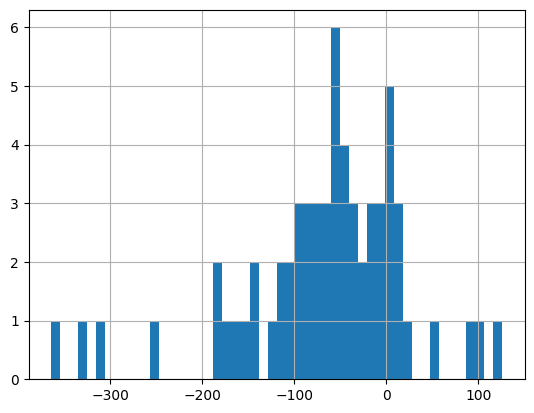

In [11]:
dist_diff_v1_df['diff'].hist(bins=50)

<AxesSubplot:ylabel='Density'>

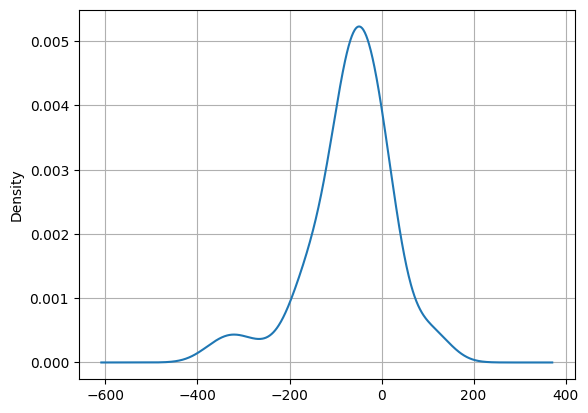

In [12]:
dist_diff_v1_df['diff'].plot.density(grid=True)

<AxesSubplot:>

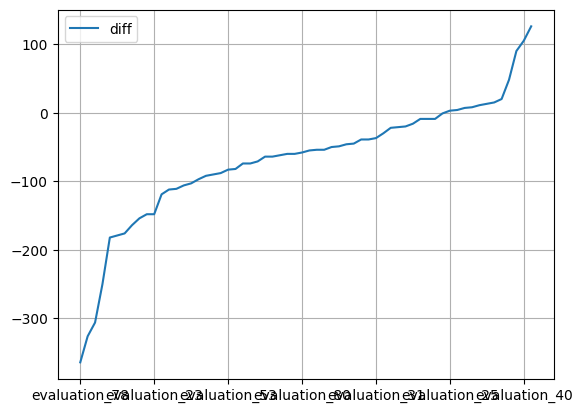

In [13]:
dist_diff_v1_df.sort_values('diff').plot(y='diff', grid=True)

### Promedio de la mejora porcentual de velocidad

In [14]:
dist_diff_v1_df['diff'].mean()

-68.09677419354838

### Cantidad de casos exitosos UTN vs Maryland

In [15]:
100*dist_diff_v1_df.loc[dist_diff_v1_df['diff']>=0].shape[0]/dist_diff_v1_df.shape[0]

19.35483870967742

In [16]:
data_check.drop('evaluation_97', inplace=True)

/tmp/ipykernel_29674/1232092048.py:1: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  data_check.drop('evaluation_97', inplace=True)


In [17]:
dist_diff_v2 = {}
for evaluation in data_check.index:
    data = data_check.loc[evaluation[0]]
    total_area = bdh.worlds[evaluation[0]]['free_area']
    dist_diff_v2[evaluation[0]] = {
        'diff': 100*int(data.loc['MARYLAND']['dist_explored_80%']-data.loc['UTN_DIST']['dist_explored_80%'])/int(data.loc['MARYLAND']['dist_explored_80%']),
        'total_area': total_area
    }
dist_diff_v2_df = pd.DataFrame(dist_diff_v2).T.sort_values('total_area')

### UTN distancia vs Maryland grafico

<AxesSubplot:>

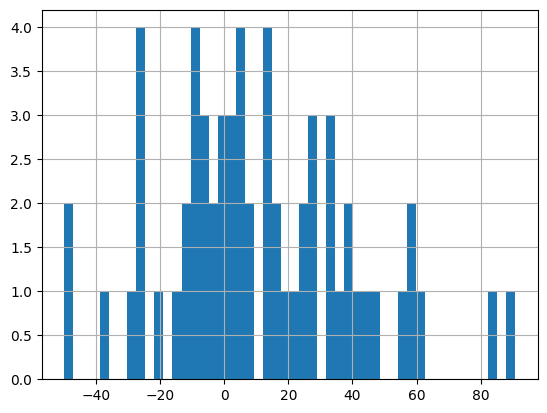

In [27]:
dist_diff_v2_df['diff'].hist(bins=50)

<AxesSubplot:ylabel='Density'>

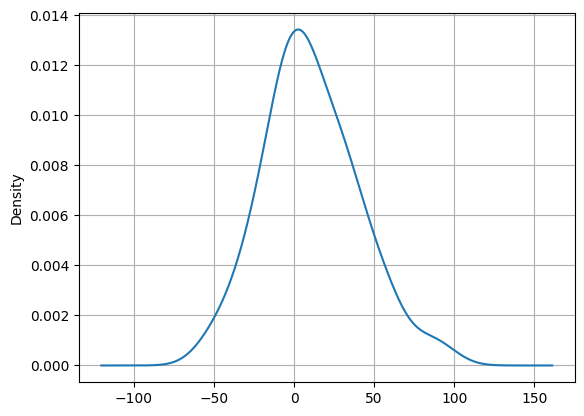

In [19]:
dist_diff_v2_df['diff'].plot.density(grid=True)

<AxesSubplot:>

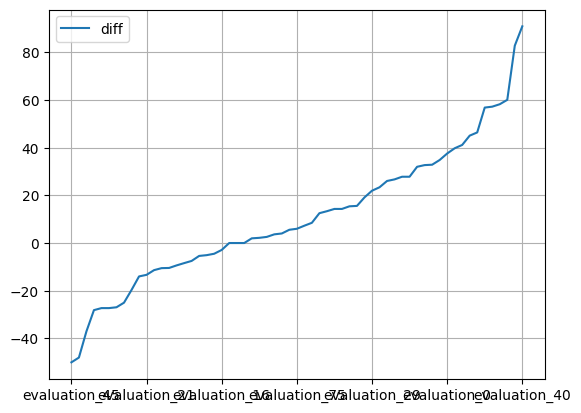

In [20]:
dist_diff_v2_df.sort_values('diff').plot(y='diff', grid=True)

### Promedio de la mejora porcentual de velocidad

In [21]:
dist_diff_v2_df['diff'].mean()

10.734157832334319

### Cantidad de casos exitosos UTN vs Maryland

In [22]:
100*dist_diff_v2_df.loc[dist_diff_v2_df['diff']>=0].shape[0]/dist_diff_v2_df.shape[0]

65.57377049180327

In [23]:
data_check

trajectory  \
evaluation_7  UTN                                                     ...   
              UTN_DIST                                                ...   
              MARYLAND                                                ...   
evaluation_5  UTN                                                     ...   
              UTN_DIST                                                ...   
...                                                                   ...   
evaluation_89 UTN_DIST                                                ...   
              MARYLAND                                                ...   
evaluation_90 UTN                                                     ...   
              UTN_DIST                                                ...   
              MARYLAND                                                ...   

                       explored_percentage total_time_sec dist_explored_20%  \
evaluation_7  UTN                99.186942            526          9.530123   
              UTN_DIST           99.420267            299         10.829154   
              MARYLAND           99.394744            311         10.143518   
evaluation_5  UTN                99.262451            409         14.115344   
              UTN_DIST           99.416186            318          6.097768   
...                                    ...            ...               ...   
evaluation_89 UTN_DIST           99.417357            128          4.264349   
              MARYLAND           99.448079            150          1.402231   
evaluation_90 UTN                99.458207            231          5.868125   
              UTN_DIST           99.179532            198          2.873741   
              MARYLAND           99.202879            176          3.533272   

                       dist_explored_50% dist_explored_80% dist_explored_85%  \
evaluation_7  UTN              99.610641        154.120499        165.103531   
              UTN_DIST         60.882462        105.326836        115.848984   
              MARYLAND         32.304539        137.660431        140.457932   
evaluation_5  UTN              50.831234        174.980286        177.483887   
              UTN_DIST         48.012703         103.43985        106.985298   
...                                  ...               ...               ...   
evaluation_89 UTN_DIST         15.608193         38.481853         39.218533   
              MARYLAND          6.305783          27.93924         27.962074   
evaluation_90 UTN              23.178328         102.98941        188.484131   
              UTN_DIST         19.705294         74.928734         106.88913   
              MARYLAND         15.357424         50.515148         74.276306   

                       dist_explored_90% dist_explored_95%  dist_total  
evaluation_7  UTN             188.111298        231.207962  399.812134  
              UTN_DIST         178.35556        184.377197  219.026199  
              MARYLAND        156.249298        165.183975  217.685242  
evaluation_5  UTN             197.832214        199.322174   337.88266  
              UTN_DIST        134.444473        140.986893  227.469666  
...                                  ...               ...         ...  
evaluation_89 UTN_DIST         43.452293         46.749916   79.747856  
              MARYLAND         29.157763         33.530617   86.624184  
evaluation_90 UTN             190.315659        194.984665  199.184387  
              UTN_DIST         107.86554        112.212776  136.777969  
              MARYLAND         76.011917         80.242157   124.69854  

[183 rows x 10 columns]

## Resultados juntos

In [24]:
dist_diff_res = {}
for evaluation in data_check.index:
    data = data_check.loc[evaluation[0]]
    total_area = bdh.worlds[evaluation[0]]['free_area']
    dist_diff_res[evaluation[0]] = {
        'UTN 100%': 100*int(data.loc['MARYLAND']['dist_total']-data.loc['UTN']['dist_total'])/int(data.loc['MARYLAND']['dist_total']),
        'UTN DIST 100%': 100*int(data.loc['MARYLAND']['dist_total']-data.loc['UTN_DIST']['dist_total'])/int(data.loc['MARYLAND']['dist_total']),
        'UTN 95%': 100*int(data.loc['MARYLAND']['dist_explored_95%']-data.loc['UTN']['dist_explored_95%'])/int(data.loc['MARYLAND']['dist_explored_95%']),
        'UTN DIST 95%': 100*int(data.loc['MARYLAND']['dist_explored_95%']-data.loc['UTN_DIST']['dist_explored_95%'])/int(data.loc['MARYLAND']['dist_explored_95%']),
        'UTN 90%': 100*int(data.loc['MARYLAND']['dist_explored_90%']-data.loc['UTN']['dist_explored_90%'])/int(data.loc['MARYLAND']['dist_explored_90%']),
        'UTN DIST 90%': 100*int(data.loc['MARYLAND']['dist_explored_90%']-data.loc['UTN_DIST']['dist_explored_90%'])/int(data.loc['MARYLAND']['dist_explored_90%']),
        'UTN 85%': 100*int(data.loc['MARYLAND']['dist_explored_85%']-data.loc['UTN']['dist_explored_85%'])/int(data.loc['MARYLAND']['dist_explored_85%']),
        'UTN DIST 85%': 100*int(data.loc['MARYLAND']['dist_explored_85%']-data.loc['UTN_DIST']['dist_explored_85%'])/int(data.loc['MARYLAND']['dist_explored_85%']),
        'UTN 80%': 100*int(data.loc['MARYLAND']['dist_explored_80%']-data.loc['UTN']['dist_explored_80%'])/int(data.loc['MARYLAND']['dist_explored_80%']),
        'UTN DIST 80%': 100*int(data.loc['MARYLAND']['dist_explored_80%']-data.loc['UTN_DIST']['dist_explored_80%'])/int(data.loc['MARYLAND']['dist_explored_80%']),
        'UTN 50%': 100*int(data.loc['MARYLAND']['dist_explored_50%']-data.loc['UTN_DIST']['dist_explored_50%'])/int(data.loc['MARYLAND']['dist_explored_50%']),
        'UTN DIST 50%': 100*int(data.loc['MARYLAND']['dist_explored_50%']-data.loc['UTN_DIST']['dist_explored_50%'])/int(data.loc['MARYLAND']['dist_explored_50%']),
        'total_area': total_area
    }
dist_diff_res_df = pd.DataFrame(dist_diff_res).T.sort_values('total_area')

<AxesSubplot:title={'center':'Version 1'}, ylabel='Density'>

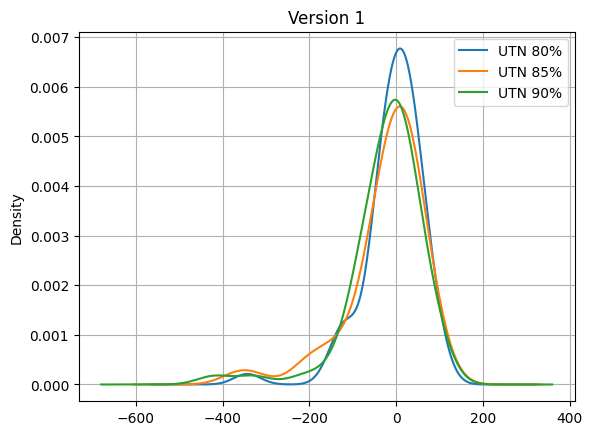

In [25]:
dist_diff_res_df[["UTN 80%","UTN 85%","UTN 90%"]].plot.density(grid=True, title="Version 1")

<AxesSubplot:title={'center':'Version 2'}, ylabel='Density'>

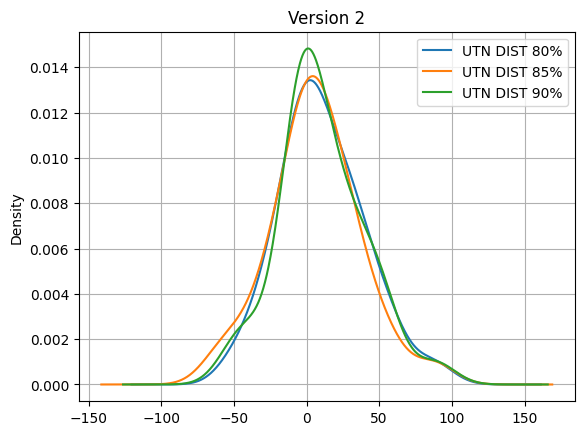

In [26]:
dist_diff_res_df[["UTN DIST 80%","UTN DIST 85%","UTN DIST 90%"]].plot.density(grid=True, title="Version 2")

## Recorrido evaluation 7

<AxesSubplot:>

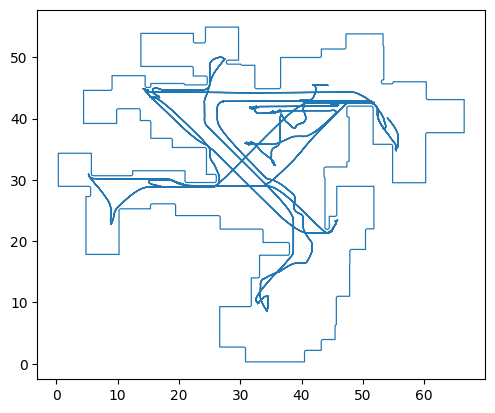

In [37]:
data_check.loc['evaluation_7'].loc['UTN']['trajectory'].buffer(0.1).plot()

<AxesSubplot:>

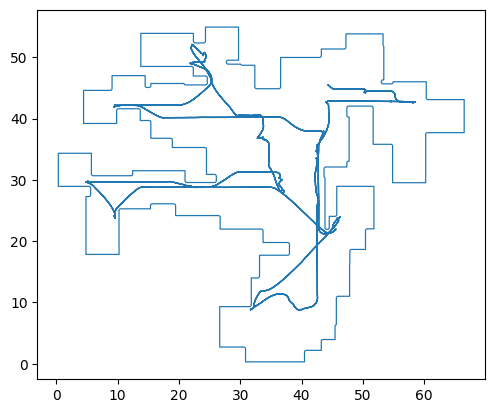

In [38]:
data_check.loc['evaluation_7'].loc['MARYLAND']['trajectory'].buffer(0.1).plot()

<AxesSubplot:>

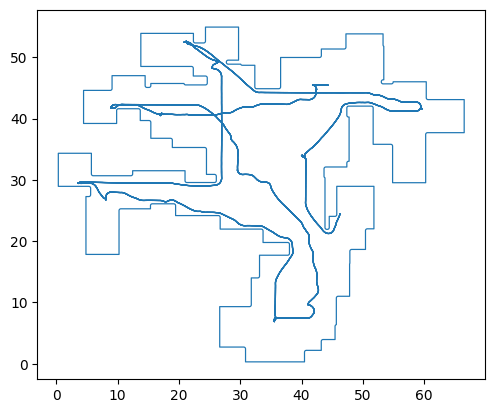

In [39]:
data_check.loc['evaluation_7'].loc['UTN_DIST']['trajectory'].buffer(0.1).plot()

## Recorrido evaluation 89

<AxesSubplot:>

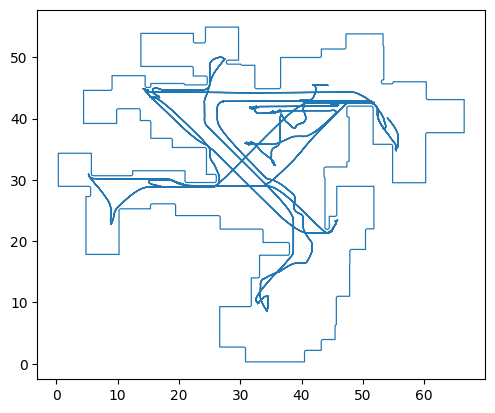

In [40]:
data_check.loc['evaluation_7'].loc['UTN']['trajectory'].buffer(0.1).plot()

<AxesSubplot:>

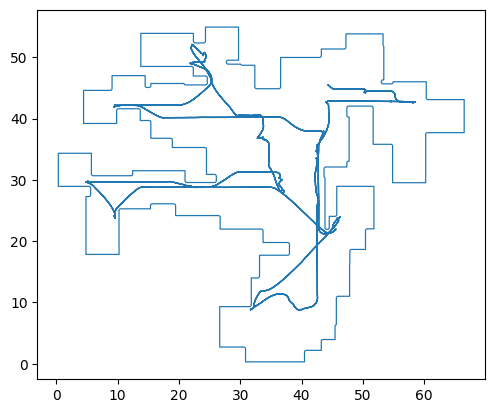

In [41]:
data_check.loc['evaluation_7'].loc['MARYLAND']['trajectory'].buffer(0.1).plot()

<AxesSubplot:>

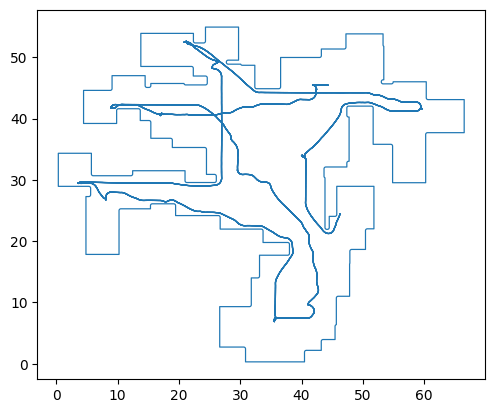

In [42]:
data_check.loc['evaluation_7'].loc['UTN_DIST']['trajectory'].buffer(0.1).plot()